## Model 3

This model focuses on the checkerboard effect in model 2. It is also discussed in: https://distill.pub/2016/deconv-checkerboard/. The CP is the same one but we are using filter size of (3,3,3) instead of (4,4,4). Since we are using a stride of 2 and 3 is not a multiple of 2, we are expecting a stronger checkerboard effect. However, maybe its not the size of stride/filter the problem, but the number of parameters that our model has, model 2 has twice as much as model 3.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from collections import OrderedDict
from DataLoader import DataGenerator 

In [2]:
model = models.Sequential()
model.add(layers.Conv3D(5, (3, 3, 3), activation='relu', strides=2, input_shape=(12, 40, 40, 1), padding="same", data_format = "channels_last"))
model.add(layers.Conv3D(10, (3, 3, 3), strides=2, padding="same", activation='relu'))
model.add(layers.Conv3DTranspose(5, (3, 3, 3), strides=2, padding="same", activation='relu'))
model.add(layers.Conv3DTranspose(1, (3, 3, 3), strides=2, padding="same", activation = None))

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 6, 20, 20, 5)      140       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 10, 10, 10)     1360      
_________________________________________________________________
conv3d_transpose (Conv3DTran (None, 6, 20, 20, 5)      1355      
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 12, 40, 40, 1)     136       
Total params: 2,991
Trainable params: 2,991
Non-trainable params: 0
_________________________________________________________________


In [4]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [5]:
months = 10
files = set('/lsdf/kit/scc/projects/abcde/1979/0'+str(i)+'/ERA5.pl.temperature.nc' for i in range(1,months))
z_train = xr.open_mfdataset(files, combine='by_coords')

bs=10 # batch size (from paper above)
dic = OrderedDict({'t': 1})  # Choosing first pressure level from variable temperature.
chunk_time = 12

#Define train and test datasets.
dg_train = DataGenerator(z_train.sel(time=slice('1979'), longitude=slice(6,15.75), latitude=slice(55.5,45.75)), dic, chunk_time, batch_size=bs, load=True, shuffle=True) 

Loading data into RAM


In [6]:
history = model.fit(dg_train, validation_data = dg_train, epochs=100)

Epoch 1/100
55/55 [==============================] - 1s 9ms/step - loss: 0.9496 - val_loss: 0.8354
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 0.7385 - val_loss: 0.5966
Epoch 3/100
55/55 [==============================] - 0s 7ms/step - loss: 0.4140 - val_loss: 0.2598
Epoch 4/100
55/55 [==============================] - 0s 7ms/step - loss: 0.2023 - val_loss: 0.1559
Epoch 5/100
55/55 [==============================] - 0s 7ms/step - loss: 0.1394 - val_loss: 0.1183
Epoch 6/100
55/55 [==============================] - 0s 7ms/step - loss: 0.1084 - val_loss: 0.0967
Epoch 7/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0893 - val_loss: 0.0817
Epoch 8/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0707 - val_loss: 0.0655
Epoch 9/100
55/55 [==============================] - 0s 8ms/step - loss: 0.0636 - val_loss: 0.0568
Epoch 10/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0580 - val_loss: 0.0512
Epoch 11/

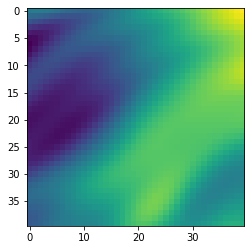

In [7]:
a = dg_train.__getitem__(8)[0]
plt.imshow(a[0,11,:,:,0])
plt.show()

In [8]:
result = model(np.expand_dims(a[0], axis=0)).numpy()

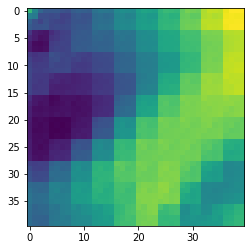

In [9]:
plt.imshow((result[0,11,:,:,0]))
plt.show()

In [10]:
test_data = z_train.sel(time=slice('1979-05-01T16:00:00','1979-05-02T03:00:00' ),level = slice(1),longitude=slice(6,15.75), latitude=slice(55.5,45.75))
test_data = test_data.transpose('time', 'latitude', 'longitude', 'level')
# Normalize
mean = test_data['t'].mean(('time', 'latitude', 'longitude')).compute()
std = test_data['t'].std('time').mean(('latitude', 'longitude')).compute() 
test_data = (test_data['t'] - mean) / std
test_data = np.expand_dims(test_data.values, axis=0)
test_data.shape

(1, 12, 40, 40, 1)

## Results

Original:

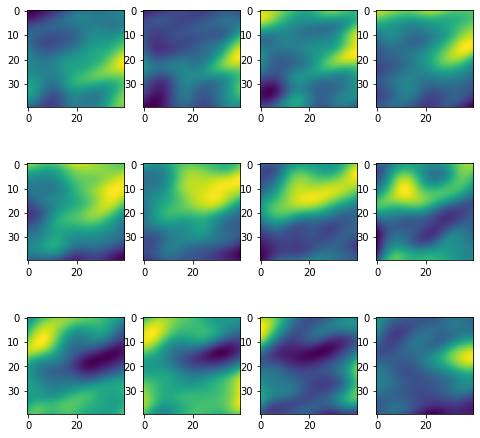

In [11]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 3
for i in range(0, columns*rows):
    img = test_data[0,i,:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

Decompressed:

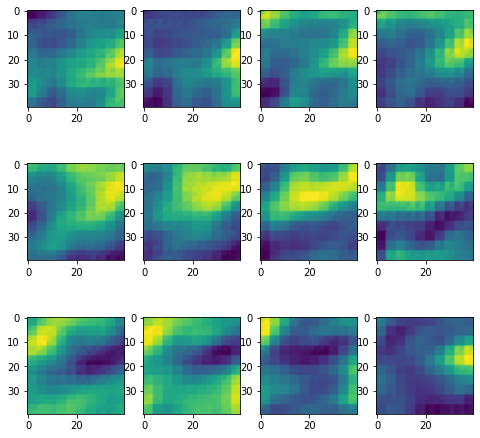

In [12]:
result2 = model(test_data).numpy()
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 3
for i in range(0, columns*rows):
    img = result2[0,i,:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

Indeed, we got a stronger checkerboard effect.